# Reconocimiento de formas

En esta lección estudiaremos el reconocimiento de objetos planos a partir de su silueta. Inicialmente estamos interesados en figuras rígidas observadas con poca inclinación. Al final de la clase seremos capaces de conseguir un resultado parecido al siguiente:

![image](https://raw.githubusercontent.com/albertoruiz/umucv/master/images/demos/shapedetect.png)

El problema puede descomponerse en varios pasos: binarización, extracción de contornos, extracción de características invariantes y clasificación.

## Bibliotecas y funciones auxiliares

In [1]:
import numpy             as np
import cv2               as cv
import matplotlib.pyplot as plt

%matplotlib inline

from skimage             import data
from scipy               import ndimage

def fig(w,h):
    plt.figure(figsize=(w,h))

def readrgb(file):
    return cv.cvtColor( cv.imread('../images/'+file), cv.COLOR_BGR2RGB) 

def rgb2gray(x):
    return cv.cvtColor(x,cv.COLOR_RGB2GRAY)

def imshowg(x):
    plt.imshow(x, 'gray')

## Binarización

Para extraer las siluetas construimos una máscara (imagen de valores lógicos) que indican los pixeles que pertenecen a los objetos de interés, separándolos del fondo. El método más sencillo es el **umbralizado**.

OpenCV proporciona [varios métodos](https://docs.opencv.org/4.7.0/d7/d4d/tutorial_py_thresholding.html).

(303, 384)


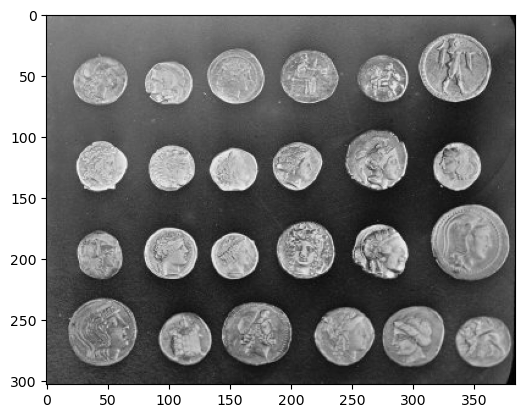

In [2]:
# imagen monocroma de prueba de scipy.ndimage
g = data.coins()
print(g.shape)
imshowg(g)

Esta imagen de prueba supone un problema para la binarización, ya que no es fácil encontrar un de gris adecuado para todas las monedas.

In [3]:
g.flatten()

array([ 47, 123, 133, ...,   4,  10,   7], dtype=uint8)

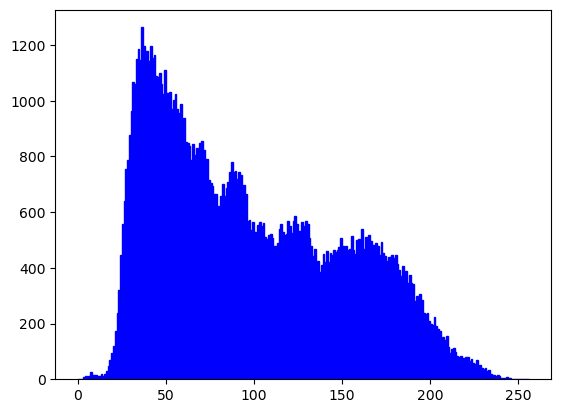

In [4]:
plt.hist(g.flatten(), bins=np.arange(257), fc='b', ec='b');

Cantidad de píxeles que tiene cada nivel, en ese caso la mayoria tienen un nivel 50

Umbral fijo, seleccionado de forma **manual**.

75.0


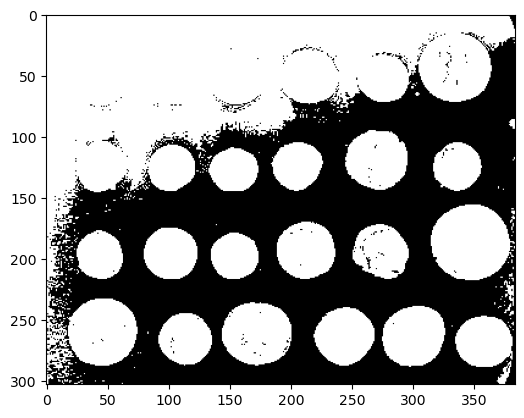

In [5]:
ret, gt = cv.threshold(g,75,255,cv.THRESH_BINARY) # umbral binario el umbral se establece a 75 y 255 el valor maximo (negro)
print(ret)
imshowg(gt);

In [6]:
from ipywidgets import interactive

g0 = g

def fun(h=128): 
    imshowg(g0>h);

interactive(fun, h=(0,255))

interactive(children=(IntSlider(value=128, description='h', max=255), Output()), _dom_classes=('widget-interac…

Umbral **automático** (global para todo el ROI): [método de Otsu](https://en.wikipedia.org/wiki/Otsu%27s_method).

Por medio de separar los pixeles del primero plano y del fondo por medio de varianza-intra-clase

-Calcula el histograma de la imagen en escala de grises.

-Normaliza el histograma para obtener una distribución de probabilidad de las intensidades de los píxeles.

-Calcula las probabilidades acumuladas del histograma y las medias acumuladas correspondientes.

-Calcula la varianza intra-clase para cada posible nivel de gris.

-Busca el umbral óptimo minimizando la varianza intra-clase.

-Utiliza el umbral óptimo para binarizar la imagen, asignando valores altos a los píxeles del primer plano y valores bajos a los del fondo.


107.0


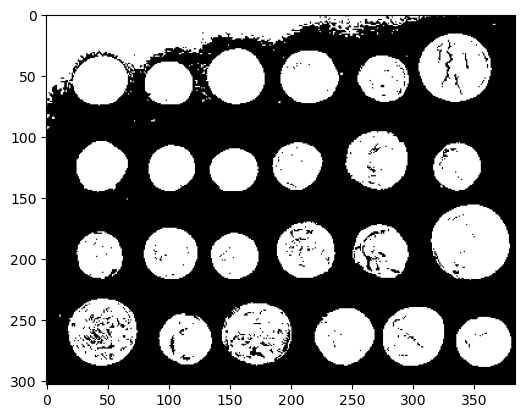

In [7]:
ret, gt = cv.threshold(g,189,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
print(ret)

imshowg(gt);

141.0


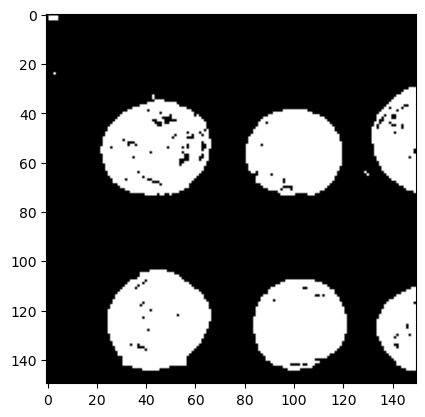

In [8]:
ret, gt = cv.threshold(g[0:150,0:150],189,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
print(ret)

imshowg(gt);

Umbral **adaptativo**:
Permiten manejar imagenes con iluminacion variable
1. División en regiones pequeñas.
2. Cálculo del umbral local. para cada region
3. Aplicación de umbralización local.
4. Combinación de resultados.


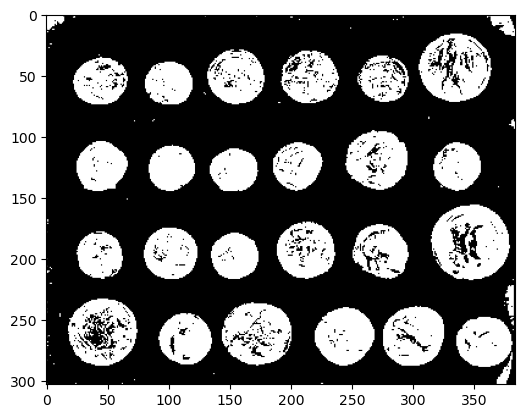

In [9]:
# Aplicar umbral adaptativo a la imagen en escala de grises 'g'
gt = cv.adaptiveThreshold(
    g,  # Imagen de entrada en escala de grises
    255,  # Valor máximo asignado a los píxeles que superen el umbral
    cv.ADAPTIVE_THRESH_GAUSSIAN_C,  # Método de umbral adaptativo (Gaussiano) calcula el valor de umbral para cada píxel como una suma ponderada de sus vecinos,
    # utilizando una ventana gaussiana(cuadrado lit).  Esto significa que los píxeles más cercanos al centro de la ventana tienen un mayor impacto en el valor de umbral que los píxeles más lejanos.
    cv.THRESH_BINARY,  # Tipo de umbralización (binario)
    101,  # Tamaño de la ventana gaussiana (debe ser impar y mayor que 1)
    -10  # Valor constante a restar del umbral calculado
)

imshowg(gt);

## Extracción de contornos

Las siluetas pueden describirse de forma equivalente pero más compacta mediante su contorno.

El diseño de un algoritmo de extracción de contornos es un ejercicio muy instructivo. OpenCV proporciona una implementación eficiente: [findContours](https://docs.opencv.org/3.4.1/d3/dc0/group__imgproc__shape.html#ga17ed9f5d79ae97bd4c7cf18403e1689a). 

88
[[[  0 273]]]
(1, 1, 2)


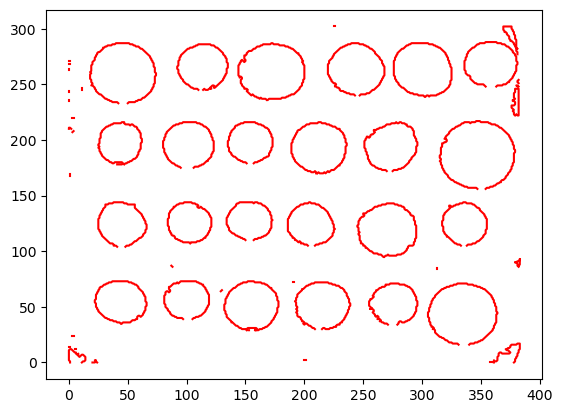

In [10]:
contours, h = cv.findContours(
    gt,  # Imagen binaria de entrada (umbralizada)
    cv.RETR_EXTERNAL,  # Modo de recuperación de contornos (solo contornos externos)
    cv.CHAIN_APPROX_SIMPLE  # Método de aproximación de contornos (compresión de puntos redundantes)
)
                                          #cv.RETR_CCOMP  , cv.CHAIN_APPROX_NONE
                                          #devuelve todos

# h  (hierarchy) da información de qué contornos están dentro de otros (útil con cv.RETR_TREE)
# contours tiene estructura nx1x2 (con una dimensión superflua !?)

print(len(contours))
print(contours[10])
print(contours[10].shape)

for x in contours:
    plt.plot(x[:,:,0],x[:,:,1],color='red')

Seleccionamos los que no son muy cortos y redimensionamos su estructura a $n\times 2$.

24


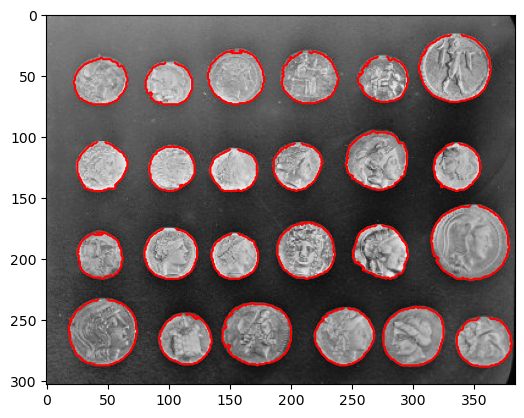

In [11]:
ok = [ x.reshape(-1,2) for x in contours if len(x)> 50 ]
#reshape(-1, 2). Esto cambia la forma del contorno de un arreglo de puntos de forma (n, 1, 2) a un arreglo de forma (n, 2), donde n es el número de puntos en el contorno.
# Esto simplifica la estructura de datos
print(len(ok))

imshowg(g);
for c in ok:
    x,y = c.T
    plt.plot(x,y,'red')

Veamos en detalle uno de ellos:

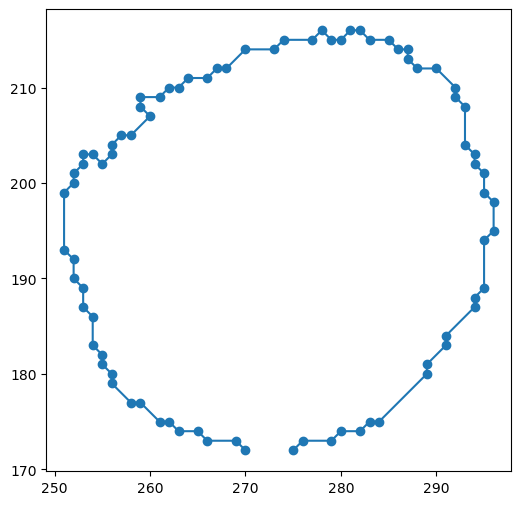

In [12]:
fig(6,6)
plt.plot(*ok[9].T,'o-'); plt.axis('equal');

Observa que el primer/último punto no se repite (con un plot simple queda el contorno no se cierra) y que el método de `cv.CHAIN_APPROX_SIMPLE` elimina nodos redundantes en el interior de fragmentos rectos.

OpenCV proporciona varias funciones para [manipular contornos](https://docs.opencv.org/4.7.0/dd/d49/tutorial_py_contour_features.html):

- Área
- Perímetro
- Convex Hull
- Momentos (centroide, elipsoide de incertidumbre)
- Reducción de nodos
- Bounding box
- Relleno de una imagen
- etc.

## Separación de componentes conexas

Un método alternativo para segmentar zonas destacadas en una imagen es obtener las componentes conexas. Se devuelven como una imagen de etiquetas.

106
int32


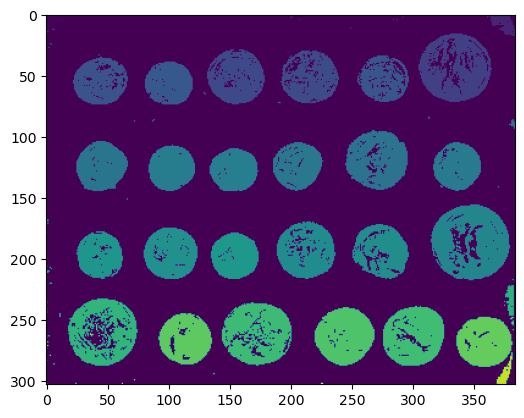

In [13]:
n,cc = cv.connectedComponents(gt)
print(n)
plt.imshow(cc);
print(cc.dtype)

Intentamos eliminar las regiones muy pequeñas con operaciones morfológicas.

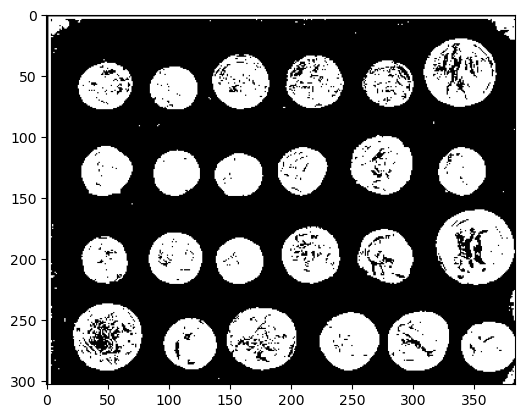

In [14]:
opening = cv.morphologyEx(gt, cv.MORPH_OPEN, np.zeros([5,5],np.uint8), anchor=(-1,-1))

imshowg(opening)

La implementación de *opening* en `scipy.ndimage` funciona bastante bien:

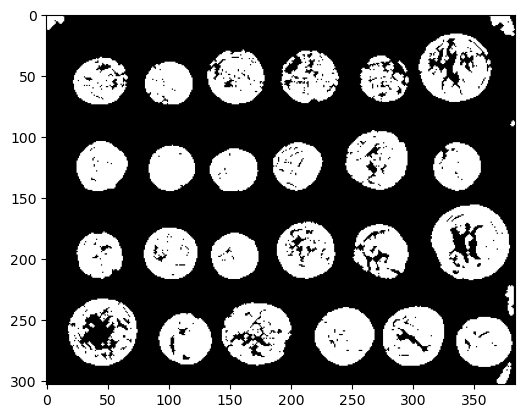

In [15]:
opening = ndimage.binary_opening(gt)

imshowg(opening)

También podemos rellenar los agujeros:

bool


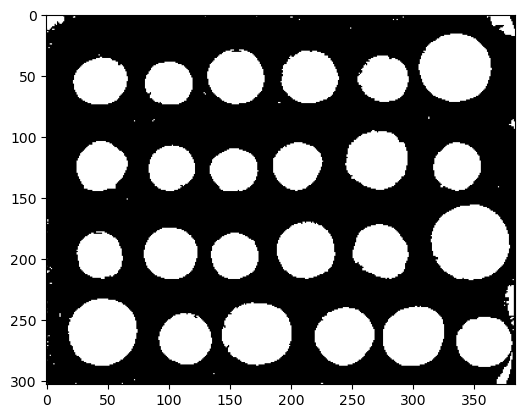

In [16]:
gtf = ndimage.binary_fill_holes(gt)
print(gtf.dtype)
imshowg(gtf);

O combinar ambas operaciones para conseguir una buena colección de regiones candidatas:

bool


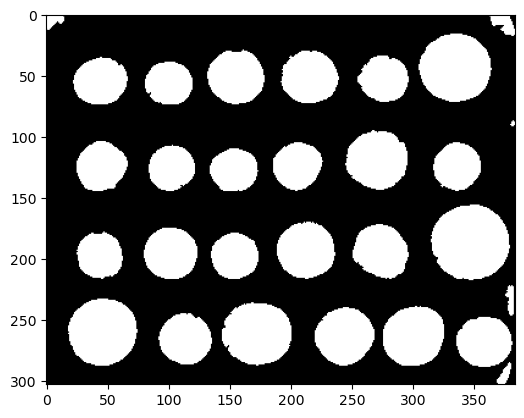

In [17]:
gtf = ndimage.binary_opening(ndimage.binary_fill_holes(gt))
print(gtf.dtype)
imshowg(gtf);

30


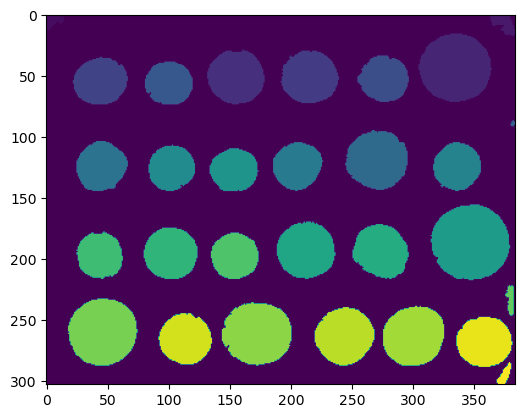

In [18]:
n,cc = cv.connectedComponents(gtf.astype(np.uint8))
print(n)
plt.imshow(cc);

Podemos crear una máscara booleana para una región concreta:

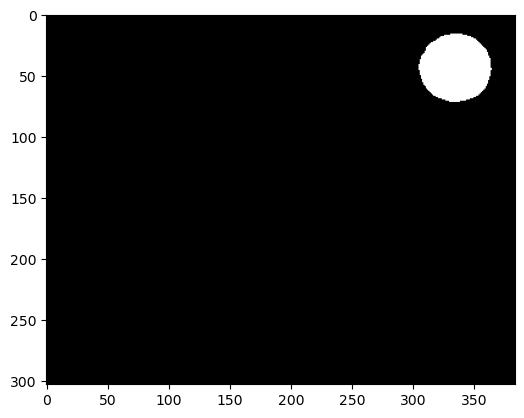

In [19]:
imshowg(cc==3)

Creamos una listas de máscaras booleanas para las regiones suficientemente grandes:

In [20]:
ok = [ cc==k for k in range(1,n) if np.sum(cc==k) > 300]
len(ok)

24

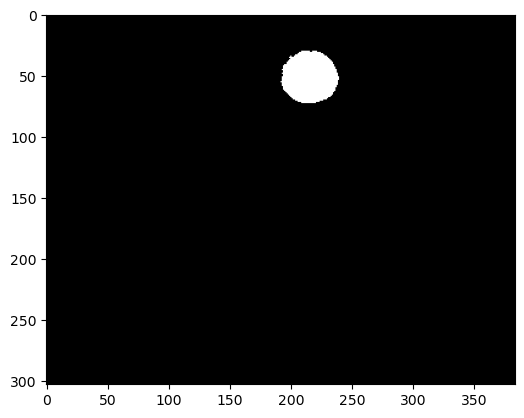

In [21]:
imshowg(ok[2])

Ahora podemos extraer cualquier región de la imagen original:

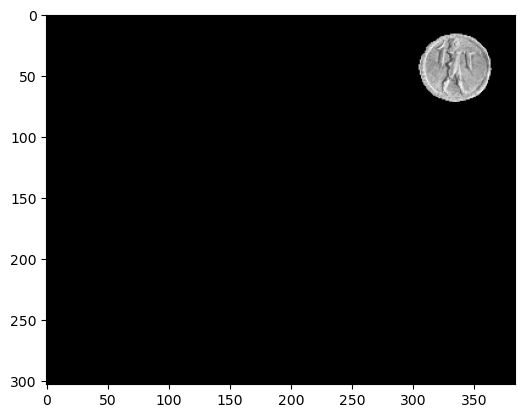

In [22]:
res = np.zeros(g.shape)
np.copyto(res, g, where = ok[0])
imshowg(res);

Otra forma:

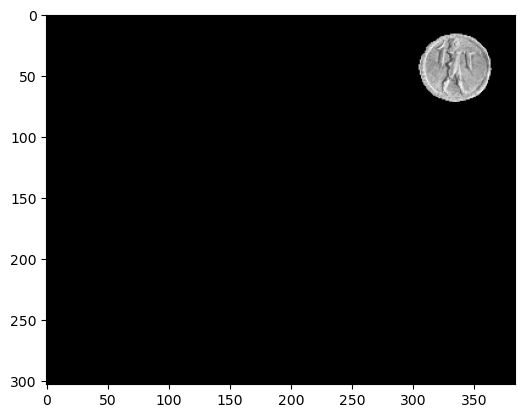

In [23]:
res = np.zeros_like(g)
res[ok[0]] = g[ok[0]]
imshowg(res)

Se puede hacer lo mismo borrando donde no esté la figura:

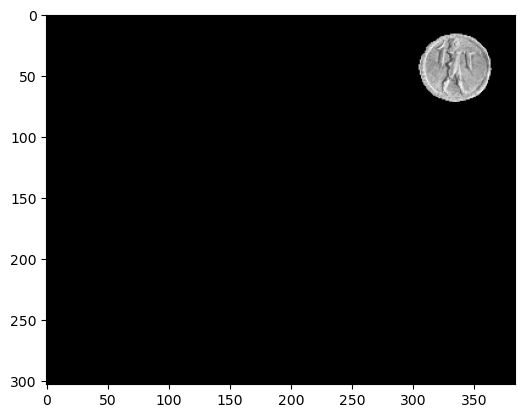

In [24]:
res = g.copy()
res[ok[0]==False] = 0
imshowg(res)

Si queremos podemos recortar las regiones:

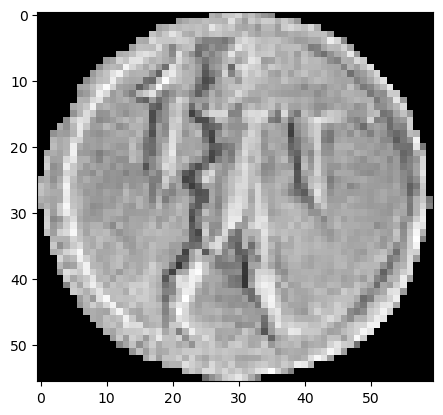

In [25]:
thing = np.argwhere(ok[0])
(x1, y1), (x2, y2) = thing.min(0), thing.max(0)

box = res[x1:x2+1,y1:y2+1]
imshowg(box)

Todo junto:

In [26]:
#view = readrgb("plate.jpg")
view = readrgb("contours.png")
print(view.shape)

ret, gt = cv.threshold(cv.cvtColor(view,cv.COLOR_RGB2GRAY),100,255,cv.THRESH_BINARY_INV)
n,cc = cv.connectedComponents(gt)
print(n)
ok = [ cc==k for k in range(1,n) ]

def sacalo(mask):
    thing = np.argwhere(mask)
    (x1, y1), (x2, y2) = thing.min(0), thing.max(0)
    box = mask[x1:x2+1,y1:y2+1].astype(np.float32)
    return box

promising = [sacalo(ok[k]) for k in range(1,len(ok))]
promising = [ p for p in promising if p.sum() > 100]
print(len(promising))

(480, 640, 3)
17
14


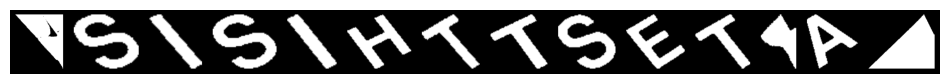

In [27]:
def normalize_size(x):
    h,w = x.shape[:2]
    r = cv.resize(x, (0,0), fx=100/h, fy = 100/h)
    return np.pad(r,10,mode='constant',constant_values=0)

fig(12,8)
imshowg(np.hstack([normalize_size(x) for x in promising]))
plt.axis('off');

Existe una variante que proporciona el bounding box, área y centro, [connected components with stats](https://docs.opencv.org/3.0-beta/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html#connectedcomponents). Tenemos un ejemplo de uso en `inrange.py`.

La funcionalidad que podemos conseguir con las componentes conexas es similar a la que proporcionan los contornos.

## MSER

*[Maximally Stable Extremal Regions](https://en.wikipedia.org/wiki/Maximally_stable_extremal_regions)* es otro método para encontrar regiones destacadas. Se basa en encontrar los diferentes umbrales de binarización cuyo cambio produce el menor cambio de área en cada zona.

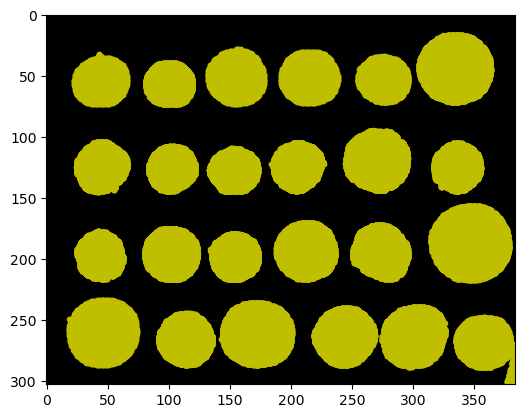

In [28]:
mser = cv.MSER_create()
#regs = mser.detectRegions(g, bboxes=None)
regs,_ = mser.detectRegions(g)

# devuelve "conjuntos" de puntos, nx2, 
# (no contornos (silueta), ni imagen de etiquetas)
# El segundo resultado es una lista de rectángulos (bounding boxes)

# dibujar con plot todos los puntos es lento
imshowg(g*0);
for x in regs:
    plt.plot(x[:,0],x[:,1],'.y')

Es más rápido rellenar una imagen vacía con los puntos obtenidos.

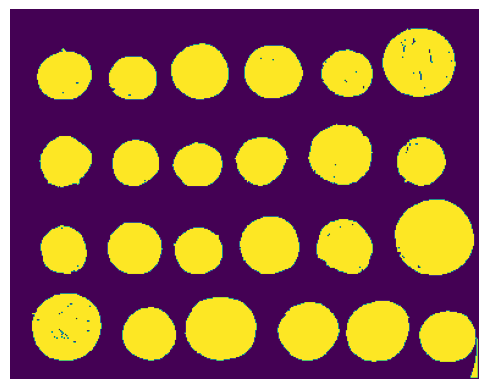

In [29]:
res = np.zeros_like(g)
for p in regs:
    x,y = p.T
    res[y,x] = 255
plt.imshow(res); plt.axis('off');

Esto nos permite obtener los contornos con `findContours`:

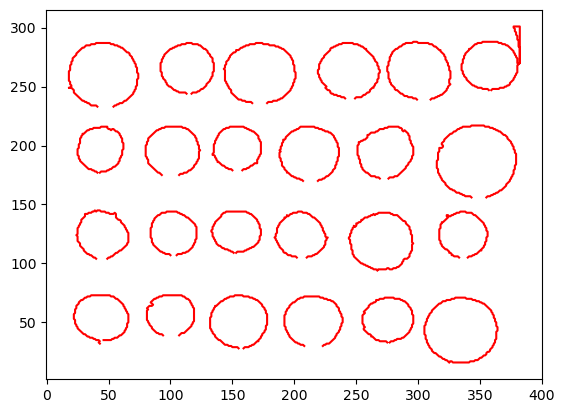

In [30]:
conts,_ = cv.findContours(res,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)[-2:]

for x in conts:
    plt.plot(x[:,:,0],x[:,:,1],color='red')

Asignando el mismo valor a todos perdemos los posibles contornos internos. Otra posibilidad es:

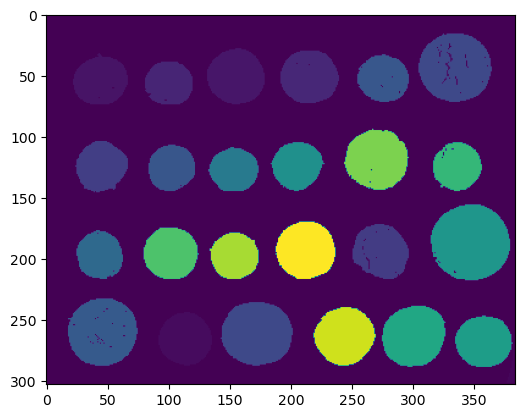

In [31]:
res = np.zeros_like(g)
for k, p in enumerate(regs):
    x,y = p.T
    res[y,x] = (k+1) % 256

plt.imshow(res);

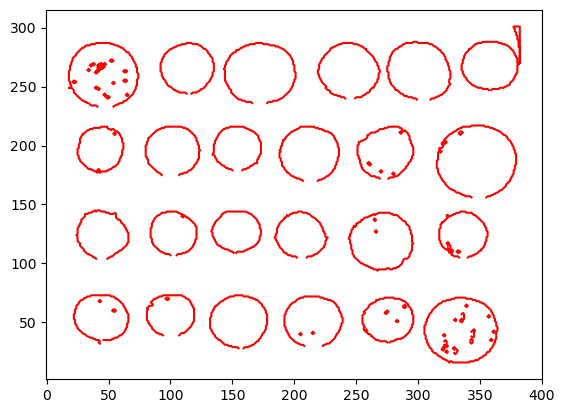

In [32]:
conts,_ = cv.findContours(res,cv.RETR_CCOMP,cv.CHAIN_APPROX_SIMPLE)

for x in conts:
    plt.plot(x[:,:,0],x[:,:,1],color='red')

(Es posible también extraer las regiones MSER en forma de *keypoint* con `mser.detect`.)

Los MSER pueden no ser disjuntos.

## Regiones convexas

Pueden extraerse mediante la [transformada de distancia](transf-dist.ipynb).

## Utilidades

Una vez vistos diferentes métodos de segmentación de regiones, vamos a definir funciones para extraer y representar contornos de forma cómoda.

In [33]:
def extractContours(g, minlen=50, holes=False):
    if holes:
        mode = cv.RETR_CCOMP
    else:
        mode = cv.RETR_EXTERNAL
    gt = cv.adaptiveThreshold(g,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,101,-10)
    contours,_ = cv.findContours(gt, mode ,cv.CHAIN_APPROX_NONE)
    ok = [c.reshape(len(c),2) for c in contours if cv.arcLength(c,closed=True) >= minlen]
    ok = sorted(ok, key=cv.contourArea, reverse=True)
    return ok

def shcont(c, col='b', nodes=False, flipy = False):
    x = c[:,0]
    y = c[:,1]
    if flipy: y = - y
    x = np.append(x,x[0])
    y = np.append(y,y[0])
    plt.plot(x,y,col)
    if nodes:
        plt.plot(x,y,col+'.',markersize=10)

## Reducción de nodos

En algunas aplicaciones puede interesar una representación compacta de los contornos reduciendo los vértices "redundantes".

(15, 2)


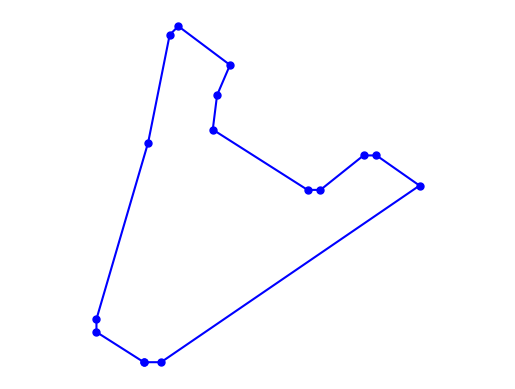

In [34]:
g = 255 - rgb2gray(readrgb('contours.png'))

conts = extractContours(g)

red = cv.approxPolyDP(conts[1],0.9,True)
red = red.reshape(red.shape[0],2)

print(red.shape)

shcont(red,nodes=True)
plt.axis('equal'); plt.axis('off');

In [35]:
def fun2(m=1,eps=1.0):
    r = cv.approxPolyDP(conts[m],eps,True)
    r = r.reshape(-1,2)
    shcont(r,nodes=True)
    shcont(conts[m],'g')
    plt.axis('equal'); plt.axis('off');


interactive(fun2, m=(0,len(conts)-1), eps=(0.0,5.0))

interactive(children=(IntSlider(value=1, description='m', max=15), FloatSlider(value=1.0, description='eps', m…

En ciertos casos es posible detectar cierto tipo de figuras (p.ej. cuadriláteros) si el número de nodos de la versión reducida con una tolerancia adecuada es el correcto, pero como los vértices suelen suavizarse en la imagen los vértices resultantes no son muy precisos.

## Clasificación de siluetas

Finalmente llegamos a nuestro principal objetivo: reconocer formas mediante **descriptores invariantes**. Inicialmente nos interesa invarianza frente a cambios de

- posición
- tamaño
- giro
- ruido
- resolución de la imagen

En primer lugar vamos capturar unos cuantos modelos.

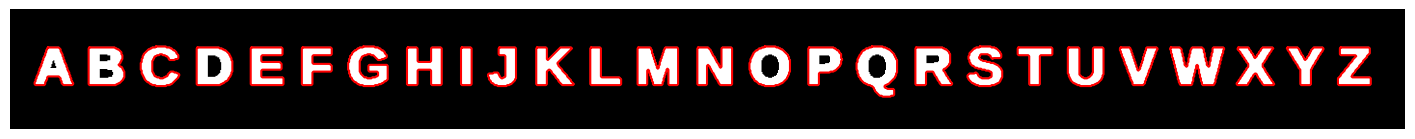

In [36]:
# invertimos la imagen porque el detector de contornos busca regiones claras (~True) sobre fondo oscuro
# pero las letras son negras
g = 255-rgb2gray(readrgb('shapes/AZ.png'))

g = ndimage.binary_dilation(g).astype(np.uint8)*255

fig(18,4)
imshowg(g); ax = plt.axis('off');
for x in extractContours(g):
    shcont(x,'r')
plt.axis(ax);

(Los hemos engordado un poco con una operación morfológica de dilatación para que se parezcan un poco más a las letras que usaremos después.)

Hay que tener cuidado porque pueden llegar desordenados. Vamos a ordenarlos de izquierda a derecha (de acuerdo con la coordenada x del primer punto), para poder asociar etiquetas a cada modelo.

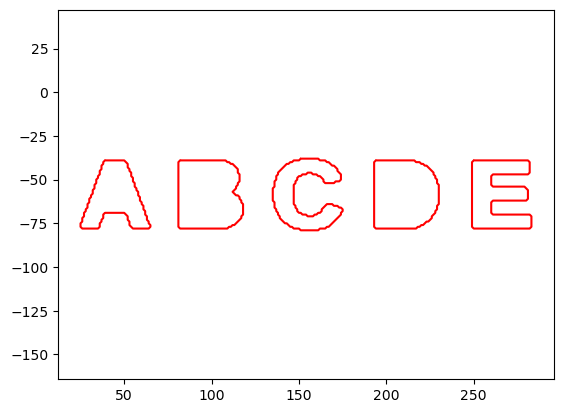

In [37]:
models = sorted(extractContours(g), key=lambda x: x[0,0])
labels = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
for x in models[0:5]:
    plt.plot(x[:,0],-x[:,1],'r')
plt.axis('equal');

Vamos a utilizar descriptores de forma frecuenciales. En el tema de análisis frecuencial vimos que cualquier función puede expresarse como una suma de senos y cosenos. Cuando el contorno de una figura se representa como una señal compleja estas componentes tienen una interpretación directa como "órbitas", como se ilustra en la siguientes animaciones:

<video src="https://raw.githubusercontent.com/albertoruiz/umucv/master/images/demos/efe.mp4" controls>efe</video>

<video src="https://raw.githubusercontent.com/albertoruiz/umucv/master/images/demos/trebol.mp4" controls>trébol</video>

En la figura siguiente se muestran las componentes dominantes situadas en el centro. Cada elipse es la combinación de los círculos de frecuencia k y -k.

![components](https://raw.githubusercontent.com/albertoruiz/umucv/master/images/demos/full-components.png)

En la figura anterior las componentes más interesantes para distinguir la forma se ven muy pequeñas. Vamos a quitar la primera, que normalmente es una elipse que engloba toda figura, y multiplicamos por 5 el tamaño de las frecuencias siguientes, que son las que realmente determinan la forma.

![components](https://raw.githubusercontent.com/albertoruiz/umucv/master/images/demos/shape-components.png)

Estas componentes frecuenciales son una especie de firma característica de la silueta. Los tamaños relativos de estas elipses permiten construir un descriptor de forma invariante a posición, tamaño, orientación, punto de partida en el muestreo, y ruido de medida (tomando las frecuencias bajas, para descartar detalles de tamaño pequeño).

Mostramos interactivamente un suavizado frecuencial de las siluetas, para hacernos una idea de cuántas componentes necesita el descriptor para distinguir aceptablemente los modelos de nuestro problema.

In [38]:
import numpy.fft as fft

def smooth(w,c):
    z = c[:,0]+c[:,1]*1j # convertimos 2D a 1D complejo
    f  = fft.fft(z)      # calculamos la descomposición frecuencial
    f[w+1:-w] = 0        # quitamos las frecuencias mayores que w 
    ccs = fft.ifft(f)    # reconstruimos la señal
    return np.vstack([np.real(ccs),np.imag(ccs)]).transpose() # reconvertimos los números complejos a pares x,y


def fun3(m=4,w=5):
    s = smooth(w,models[m])
    plt.plot(s[:,0],-s[:,1]); plt.axis('equal');

interactive(fun3, m=(0,len(models)-1), w=(0,40))

interactive(children=(IntSlider(value=4, description='m', max=25), IntSlider(value=5, description='w', max=40)…

No parece necesario conservar frecuencias mucho más altas que 10.

El invariante frecuencial de un contorno puede definirse así:

In [39]:
def invar(c, wmax=10):
    x,y = c.T
    z = x+y*1j
    f  = fft.fft(z)
    fa = abs(f)                     # para conseguir invarianza a rotación 
                                    # y punto de partida
    s = fa[1] + fa[-1]              # el tamaño global de la figura para normalizar la escala
    v = np.zeros(2*wmax+1)          # espacio para el resultado
    v[:wmax] = fa[2:wmax+2];        # cogemos las componentes de baja frecuencia, positivas
    v[wmax:] = fa[-wmax-1:];        # y negativas. Añadimos también la frecuencia -1, que tiene
                                    # que ver con la "redondez" global de la figura

    if fa[-1] > fa[1]:              # normalizamos el sentido de recorrido
        v[:-1] = v[-2::-1]
        v[-1] = fa[1]

    return v / s

Comprobamos que descriptor es realmente invariante a posición, tamaño, orientación, punto de partida y sentido de recorrido en el muestreo y ruido. (Y diferente en los distintos modelos.)

In [40]:
invar(models[0],3)

array([0.16524975, 0.06212112, 0.10147801, 0.01475016, 0.06402732,
       0.25118374, 0.00196281])

In [41]:
invar(np.flipud(3*np.roll(models[0],37,0)+np.array([[100,200]])),3)

array([0.16524975, 0.06212112, 0.10147801, 0.01475016, 0.06402732,
       0.25118374, 0.00196281])

Ahora capturamos los contornos de la escena que nos interesa reconocer.

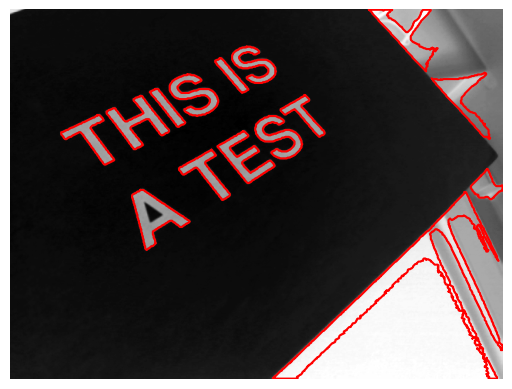

In [42]:
img = readrgb('contours.png')

g = 255-rgb2gray(img)
things = extractContours(g,holes=False)

imshowg(g); ax = plt.axis('off');
for x in things:
    shcont(x,'r')
plt.axis(ax);

Para facilitar la clasificación construimos una función que compara un vector con un conjunto de modelos y devuelve ordenadas las distancias y la correspondiente etiqueta.

In [43]:
def mindist(c,mods,labs):
    import numpy.linalg as la
    ds = [(la.norm(c-mods[m]),labs[m]) for m in range(len(mods)) ]
    return sorted(ds, key=lambda x: x[0])

La probamos con uno de los contornos:

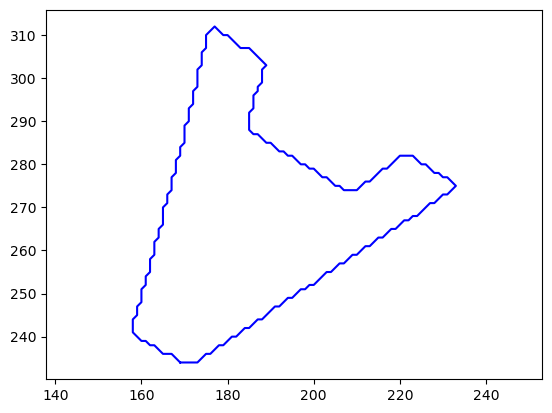

In [44]:
x = things[1]
shcont(x); plt.axis('equal');

In [45]:
feats = [invar(m) for m in models]

mindist(invar(x),feats,labels)[0:5]

[(0.05607558077611318, 'A'),
 (0.12082859418382547, 'Y'),
 (0.21503161451778127, 'P'),
 (0.2199482340846804, 'R'),
 (0.22807077699844472, 'T')]

Y ya con toda la imagen, mostrando solo las manchas que se clasifican aceptablemente bien:

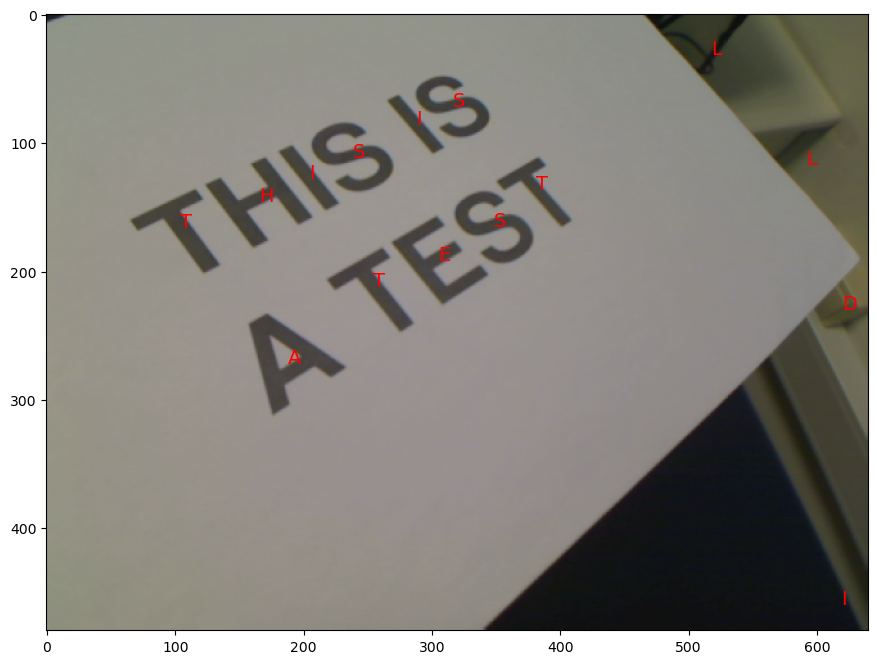

In [46]:
fig(12,8)
plt.imshow(img)
for x in things:
    d,l = mindist(invar(x),feats,labels)[0]
    if d < 0.2:
        cx,cy = np.mean(x,0)
        plt.text(cx,cy,l,color='red',fontsize=14)

Hay que tener en cuenta que se trata de una vista en perspectiva, más compleja que un cambio de tamaño y rotación. Por tanto, hay que aumentar la tolerancia en la distancia entre descriptores, lo que produce "falsos positivos". Si queremos evitarlos perderíamos detecciones correctas.

Algunos falsos positivos se podrían evitar eliminando de antemano contornos muy grandes o muy pequeños, o que tocan con los límites de la imagen.

Veamos otros ejemplos:

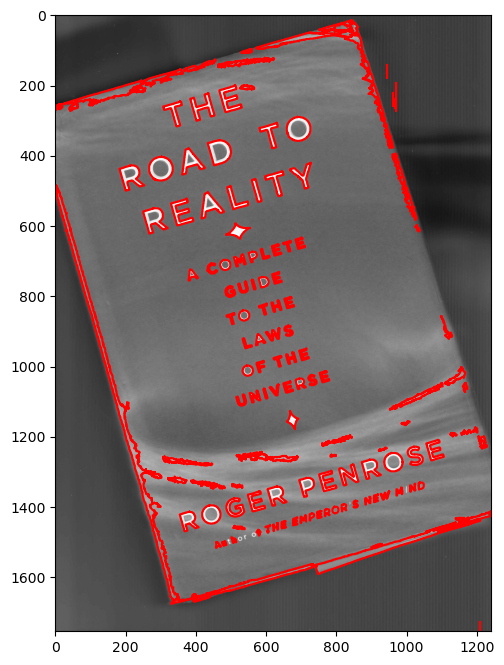

In [47]:
#img = readrgb('letras.png')[50:260,80:520];  g = rgb2gray(img)
#img = readrgb('goldstein.jpg'); g = 255 - rgb2gray(img)
img = cv.resize(readrgb('penrose.jpg'),(0,0),fx=0.5,fy=0.5); g = rgb2gray(img)

things = extractContours(g,holes=False,minlen=50)

fig(12,8)
imshowg(g); ax = plt.axis();
for x in things:
    shcont(x,'r')
plt.axis(ax);

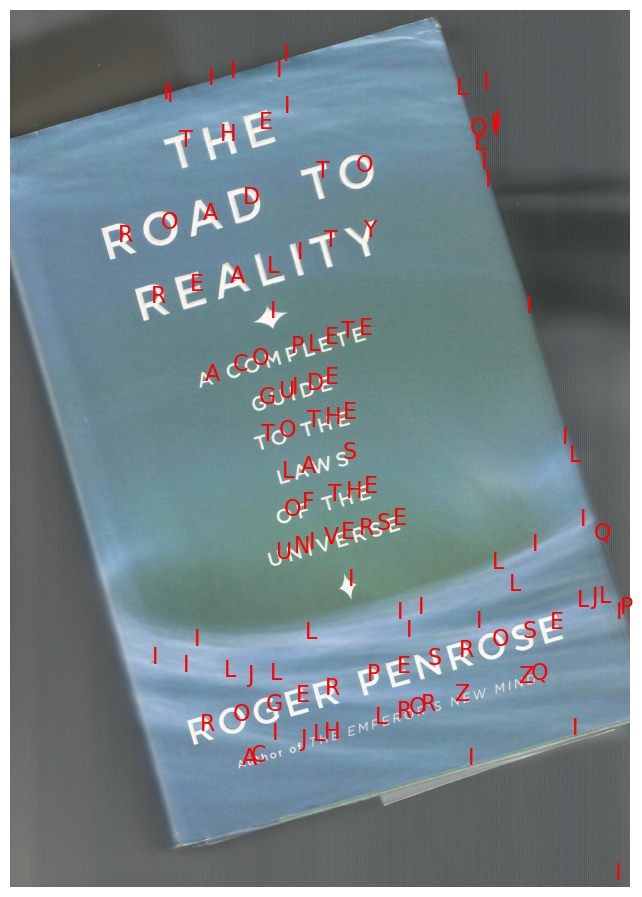

In [48]:
fig(8,12)
plt.imshow(img); plt.axis('off');
for x in things:
    d,l = mindist(invar(x),feats,labels)[0]
    if d < 0.2:
        cx,cy = np.mean(x,0)
        plt.text(cx,cy,l,color='red',fontsize=16)

Pueden producirse fallos causados por un tipo de letra distinto al de los modelos, por deformaciones de perspectiva y por fallos de detección, al quedarse letras pegadas.

La invarianza a inclinación moderada (en condiciones de perspectiva débil, que estudiaremos en una clase posterior) se consigue mediante la transformación de *whitening*.

### Capacidad de discriminación

Veamos gráficamente los vectores invariantes de los palos de la baraja.

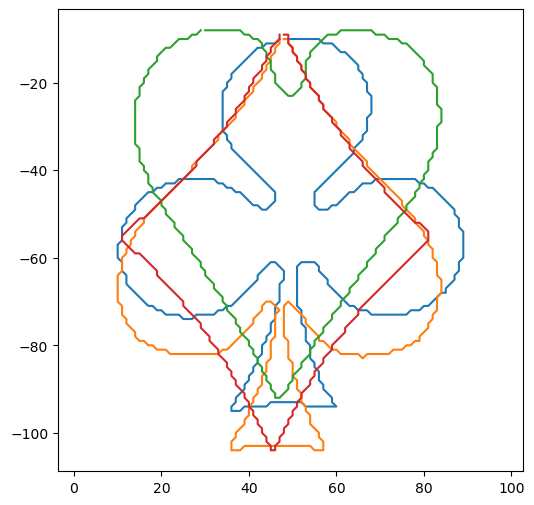

In [49]:
suits = ['../images/shapes/{}.png'.format(s) for s in 'trebol pica corazon diamante'.split()]
fig(6,6)
for f in suits:
    img = readrgb(f)
    g = 255-rgb2gray(img)
    c = extractContours(g)[0]
    x,y = c.T
    plt.plot(x,-y)
plt.axis('equal');

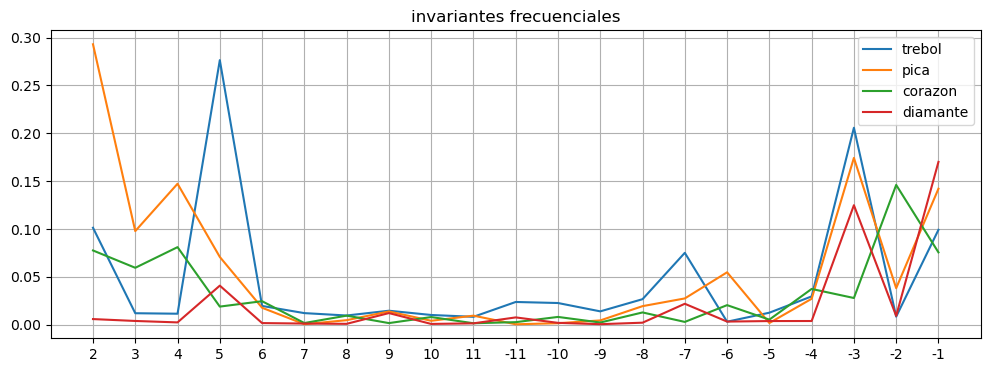

In [50]:
fig(12,4)
for f in suits:
    img = readrgb(f)
    g = 255-rgb2gray(img)
    c = extractContours(g)[0]
    v = invar(c)
    plt.plot( v, label=f.split('/')[-1][:-4])

plt.legend();
plt.grid()
plt.xticks(np.arange(21),list(range(2,12))+list(range(-11,0)));
plt.title('invariantes frecuenciales');

En principio parecen distinguibles sin necesidad de usar frecuencias muy altas. Pero habría que hacer un estudio más cuidadoso teniendo en cuenta las condiciones reales de trabajo.

## Misc

Código para preparar las animaciones.

In [51]:
from matplotlib import animation, rc
rc('animation', html='html5')

In [52]:
def makeAnimation(c, video=True):
    global track
    c = c / (c.max(axis=0)-c.min(axis=0)).max() *1.5
    z = c[:,0]-c[:,1]*1j
    f  = fft.fft(z)

    def ellip(w):
        nf = np.zeros_like(f)
        nf[[-w,w]] = f[[-w,w]]
        z = fft.ifft(nf)
        return np.array([np.real(z), np.imag(z)])[:,:1+len(f)//w]

    def pos(t,w):
        z = (f[w]*np.exp(2*np.pi*w*t*1j) + f[-w]*np.exp(-2*np.pi*w*t*1j))/len(c)
        return np.array([[np.real(z)], [np.imag(z)]])

    def upto(t,w):
        return sum([pos(t,x) for x in range(1,1+w)])

    fig, ax = plt.subplots(figsize=(5,5))

    ax.set_xlim(( -1,1))
    ax.set_ylim((-1,1))
    plt.axis('off')
    if video:
        plt.close()

    track = []

    [line0] = ax.plot([],[],color='green',lw=3)

    lines = [ax.plot([],[],color='gray',lw=2)[0] for k in range(1,8+1)]

    [point1] = ax.plot(*(upto(0,1)),'.', color='gray', markersize=16) 
    [point2] = ax.plot(*(upto(0,2)),'.', color='gray', markersize=13) 
    [point3] = ax.plot(*(upto(0,3)),'.', color='gray', markersize=10) 

    [point] = ax.plot(*(upto(0,8)),'.',markersize=15)

    e1 = np.hstack([ellip(1),ellip(1)[:,[0]]])
    lines[0].set_data(*e1)

    def fotogram(n):
        global track
        t = n/400

        if n==401:
            track = []
        if n>400:
            wmax = 9
        else:
            wmax = 3

        for k,l in enumerate(lines[1:wmax]):
            l.set_data(*upto(t,k+1)+ellip(k+2))

        point1.set_data(*upto(t,1))
        point2.set_data(*upto(t,2))
        point3.set_data(*upto(t,3))

        track.append(upto(t,wmax)) 
        line0.set_data(*np.array(track).T)
        point.set_data(*upto(t,wmax))
        return ()

    if video:
        def create(frames,interval):
            return animation.FuncAnimation(fig, fotogram, frames=frames, interval=interval, blit=True, repeat=False)
        return create
    else:
        fig.canvas.toolbar_visible = False
        fig.canvas.header_visible = False
        fig.canvas.footer_visible = False
        fig.canvas.capture_scroll = False

        import time
        def play(n):
            global track
            track = []
            for k in range(n):
                fotogram(k)
                fig.canvas.draw()
                time.sleep(0.01)

        return play

In [53]:
%matplotlib inline
create = makeAnimation(models[5])
create(frames=80, interval=1000/25)

In [54]:
# %matplotlib widget
# play = makeAnimation(models[5], video=False)

In [55]:
# play()